# AdaFlix Milestone 2

This notebook presents some preprocessing of our datasets, as well as an initial analysis of factors that contribute to a movie's financial success. In the first part of the notebook we clean the datasets and come up with features that will be used to perform some statistical analysis. The analysis will tell us what the significant factors of a movie's financial success are.

# Imports, loading and downloads

In [216]:
#! pip install spacy
#!pip install -U textblob
#!pip install --user -U nltk
#!python -m spacy download en_core_web_sm

In [217]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import nltk
import spacy
import string
from scipy import stats
from textblob import TextBlob
from collections import Counter
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.corpus import subjectivity
from nltk.tokenize import word_tokenize
from spacy.lang.en.examples import sentences
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scripts.helper import *
from scripts.plot import *
from loads import *
import os

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

PATH_FOLDER = "MovieSummaries/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [218]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

## CLEANING

#### MOVIE METADATA Cleaning

We are first extracting variables that have the form (ID : variable) tuples to be able to use these features.

In [219]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

A lot of columns in the dataframe contain IDs that we don't need, we are thus, dropping them.

In [220]:
# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

Our main interest is to see what features result in higher boxe office revenues, so we need to drop movies with missing revenue (Nan).

In [221]:
# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie box office revenue'], inplace=True)

One of our feature of interest is the release date of the movies. We are thus, processing the column, for it to be usable in our analysis. We extract Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together).

In [222]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie release date"], inplace=True)
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie release date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie release date'],errors='coerce').dt.month

### Inflation

To be able to compare the the relative box office revenues across different years, we need to take inflation into account.

In [223]:
# Calculate cumulative inflation to 2022 using the last available annual inflation rate
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
# Merge the movie DataFrame with the inflation DataFrame on the 'Year' column
movie_with_inflation = pd.merge(movie_df, inflation.drop(['Annual'], axis=1), on='Year')
# Calculate revenue with inflation by multiplying 'Movie box office revenue' with the 'Cumulative Inflation to 2022'
movie_with_inflation['Revenue_with_inflation'] = movie_with_inflation['Movie box office revenue'] * movie_with_inflation['Cumulative Inflation to 2022']

The original distribution of the inflated movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation on the x-axis, we approximate a "more" normal distribution, making the data more amenable to statistical analyses that assume normality.

Text(0, 0.5, 'Number of movies')

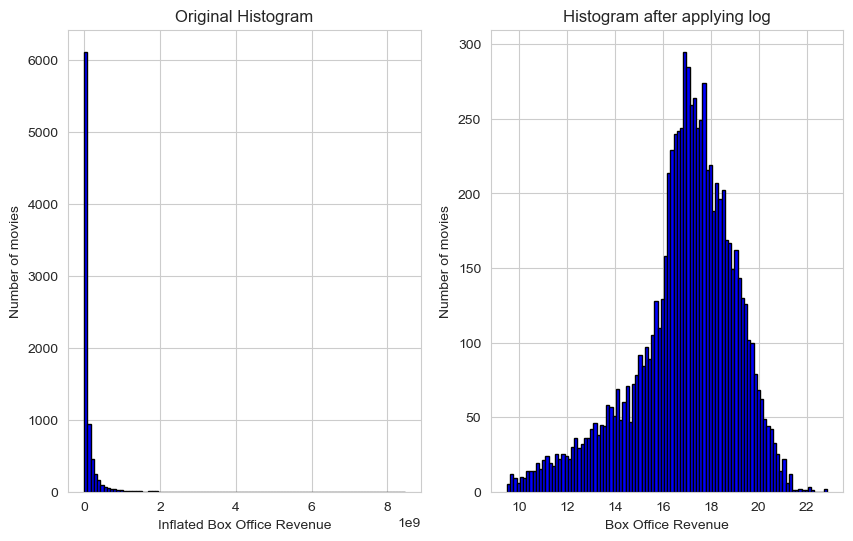

In [224]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
movie_with_inflation['Revenue_with_inflation'].hist(ax=axs[0], bins=100, color='blue', edgecolor='black')
movie_with_inflation['log_revenues'] = np.log(movie_with_inflation['Revenue_with_inflation'])
movie_with_inflation['log_revenues'].hist(ax=axs[1], bins=100, color='blue', edgecolor='black')
axs[0].set_title('Original Histogram')
axs[0].set_xlabel('Inflated Box Office Revenue')
axs[0].set_ylabel('Number of movies')
axs[1].set_title('Histogram after applying log')
axs[1].set_xlabel('Box Office Revenue')
axs[1].set_ylabel('Number of movies')

#### CHARACTER METADATA Cleaning

Again, a lot of columns in the dataframe contain IDs that we don't need, as well as actors' heights, we are thus, dropping them.

In [225]:
# Dropping unnecessary character-related columns from the DataFrame
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

The plot summaries, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

In [226]:
# Form more details run the scripts/corenlp_plot_summary_parsing.ipynb 
core_nlp_df = pd.read_csv("external_dataset/boxofficemojo_dataframe.csv")
core_nlp_df

,Rank,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,1,Avatar,"$2,923,706,026","$785,221,649",26.9%,"$2,138,484,377",73.1%,2009
1,2,Avengers: Endgame,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
2,3,Avatar: The Way of Water,"$2,320,250,281","$684,075,767",29.5%,"$1,636,174,514",70.5%,2022
3,4,Titanic,"$2,264,743,305","$674,292,608",29.8%,"$1,590,450,697",70.2%,1997
4,5,Star Wars: Episode VII - The Force Awakens,"$2,071,310,218","$936,662,225",45.2%,"$1,134,647,993",54.8%,2015
...,...,...,...,...,...,...,...,...
2595,996,Hot Shots!,"$181,096,164","$69,467,617",38.4%,"$111,628,547",61.6%,1991
2596,997,Road to Perdition,"$181,001,478","$104,454,762",57.7%,"$76,546,716",42.3%,2002
2597,998,Kill Bill: Vol. 1,"$180,906,076","$70,099,045",38.8%,"$110,807,031",61.2%,2003
2598,999,The Scorpion King,"$180,630,907","$91,047,077",50.4%,"$89,583,830",49.6%,2002


## Splitting

We are now splitting the dataframes into many small different dataframes for each feature. Each small df has one feature and 'log_revenues'. These small dataframes are created for the analysis to be easier.

In [227]:
movie_with_inflation.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie Languages,Movie Countries,Movie Genres,Year,Month,Cumulative Inflation to 2022,Revenue_with_inflation,log_revenues
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,1.652484,2.315268e+07,16.957621
1,156558,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",2001,6.0,1.652484,4.855272e+07,17.698161
2,5566878,Tortilla Soup,2001-08-24,4574762.0,103.0,"[English Language, Spanish Language]",[United States of America],"[Romantic comedy, Indie, Slice of life story, ...",2001,8.0,1.652484,7.559723e+06,15.838345
3,570743,Down to Earth,2001-02-12,71186502.0,87.0,[English Language],"[United States of America, Australia, Canada, ...","[Romantic comedy, Romance Film, Fantasy, Comedy]",2001,2.0,1.652484,1.176346e+08,18.583094
4,366111,Shallow Hal,2001-11-01,141069860.0,113.0,[English Language],"[United States of America, Germany]","[Romantic comedy, Fantasy, Comedy, Drama, Roma...",2001,11.0,1.652484,2.331158e+08,19.267046


In [228]:
# Extracting 'Movie runtime' and 'log_revenues' columns into a new dataframe
movie_runtime_df = movie_with_inflation[['Movie runtime', 'log_revenues']].copy()
# Extracting 'Movie Languages' and 'log_revenues' columns into a new dataframe
movie_languages_df = movie_with_inflation[['Movie Languages', 'log_revenues']].copy()
# Extracting 'Movie Countries' and 'log_revenues' columns into a new dataframe
movie_countries_df = movie_with_inflation[['Movie Countries', 'log_revenues']].copy()
# Extracting 'Movie Genres' and 'log_revenues' columns into a new dataframe
movie_genres_df = movie_with_inflation[['Movie Genres', 'log_revenues']].copy()
# Extracting 'Month' and 'log_revenues' columns into a new dataframe
months_df = movie_with_inflation[['Month', 'log_revenues']].copy()
# Extracting 'Year' and 'log_revenues' columns into a new dataframe
years_df = movie_with_inflation[['Year', 'Revenue_with_inflation','log_revenues']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature

In [229]:
# Drop NaNs in each small dataframes
movie_runtime_df.dropna(subset=['Movie runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie Genres'], inplace=True)
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

We then need to merge character and movie dataframes, to be able to extract information on actors and their impact on box office revenues

In [230]:
# Merging character_df and movie_with_inflation DataFrames on 'Wikipedia movie ID'
# Dropping the 'Movie release date' column from character_df to avoid duplicate columns after the merge
character_movie_merged_df = pd.merge(character_df.drop(['Movie release date'],axis=1), movie_with_inflation, on=['Wikipedia movie ID'])


One of our feature will be the percentage of women actresses in movies, so we need to get this information

In [231]:
# Create a new DataFrame containing relevant columns from the original DataFrame
actor_gender_movie_df = character_movie_merged_df[['Movie name','log_revenues','Actor name','Actor gender','Revenue_with_inflation']].copy()
# Drop rows with missing values
actor_gender_movie_df.dropna(inplace=True)
# Compute percentage of women in each movies
actor_gender_movie_df['Percentage_Women'] = (actor_gender_movie_df.groupby('Movie name')['Actor gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of int type
                                             )

In [232]:
# Creating a DataFrame with actor gender, movie name, and log_revenues from the merged DataFrame
movie_gender_df = actor_gender_movie_df[['Percentage_Women','Movie name','log_revenues','Revenue_with_inflation']].copy()
# Removing duplicate rows from actor_gender_df based on all columns
movie_gender_df = movie_gender_df.drop_duplicates()
# Creating a new DataFrame with percentage women and log_revenues, dropping rows with missing percentage women
gender_df = movie_gender_df[['Percentage_Women','log_revenues','Revenue_with_inflation']].copy()
gender_df.dropna(subset=['Percentage_Women'], inplace=True)

In [233]:
# Creating a DataFrame with actor name, actor age at movie release, and log_revenues from the merged DataFrame
actor_df = character_movie_merged_df[['Actor name','Actor age at movie release','log_revenues','Revenue_with_inflation']].copy()
actor_df.dropna()

,Actor name,Actor age at movie release,log_revenues,Revenue_with_inflation
0,Wanda De Jesus,42.0,16.957621,2.315268e+07
1,Natasha Henstridge,27.0,16.957621,2.315268e+07
2,Ice Cube,32.0,16.957621,2.315268e+07
3,Jason Statham,33.0,16.957621,2.315268e+07
4,Clea DuVall,23.0,16.957621,2.315268e+07
...,...,...,...,...
100848,Roland Culver,64.0,17.746917,5.097861e+07
100849,Michael Hordern,53.0,17.746917,5.097861e+07
100850,Reginald Beckwith,56.0,17.746917,5.097861e+07
100851,Gong Yoo,32.0,17.503715,3.997302e+07


## Quantization

In this section we transform runtimes, female percentages and years into categories to be able to run a regression analysis with categorical features. For example, if the female percentage of movie "x" is 23%, it will be associated to the interval [20%,30%]. Similarly, if the movie runtime of movie "x" is 123 minutes, it will be associated to the interval [100min,130min].

In [234]:
# Calculate the minimum and maximum years in the 'Year' column
min_year = years_df['Year'].min()
max_year = years_df['Year'].max()

# Create intervals of 10 years and assign labels based on the minimum and maximum years
years_df['year_intervals'] = pd.cut(years_df['Year'], 
                                    bins=range(min_year, max_year + 11, 10),  # Define bins for 10-year intervals
                                    labels=[f"{start}-{start + 9}" for start in range(min_year, max_year, 10)],  # Create labels for intervals
                                    include_lowest=True)  # Include the lowest value in the interval

# The 'year_intervals' column now contains the corresponding interval for each year

In [235]:
# Cast 'Movie runtime' to integers
movie_runtime_df['Movie runtime'] = movie_runtime_df['Movie runtime'].astype(int)

# Calculate the minimum and maximum runtimes in the 'Movie runtime' column
min_runtime = movie_runtime_df['Movie runtime'].min()
max_runtime = movie_runtime_df['Movie runtime'].max()

# Create intervals of 30 for runtimes until 220, and a separate interval for values greater than 220 but smaller than the maximum runtime
runtime_bins = [i for i in range(min_runtime, min(max_runtime, 221), 30)] + [float('inf')]

# Create labels for the runtime intervals
runtime_labels = [f"{start}-{start + 29}" if start + 29 < min(max_runtime, 220) else f"{min(max_runtime, 220)+1}-{max_runtime}" for start in range(min_runtime, min(max_runtime, 221), 30)]

# Assign the intervals to the 'Movie runtime' column
movie_runtime_df['runtime_intervals'] = pd.cut(movie_runtime_df['Movie runtime'],
                                       bins=runtime_bins,
                                       labels=runtime_labels,
                                       include_lowest=True)

# The 'runtime_intervals' column now contains the corresponding interval for each runtime

In [236]:
# Create intervals of size 10 for the 'Percentage Women' column
gender_df['Percentage_Women_Intervals'] = pd.cut(gender_df['Percentage_Women'],
                                                             bins=range(0, 101, 10),
                                                             labels=[f"{start}-{start + 9}" for start in range(0, 100, 10)],
                                                             include_lowest=True)

# Data analysis

We know have everything in place to perform our analysis. We first check if there is a correlation between the release month of a movie and the box office revenue.

In [237]:
# Compute the correlation between release month and log revenues
stats.spearmanr(months_df['Month'], months_df['log_revenues'])

SignificanceResult(statistic=0.09366287903172422, pvalue=1.0366280870920575e-14)

By running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and release month are uncorrelated. Investigating which months result in higher box office revenues is thus a good idea.

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


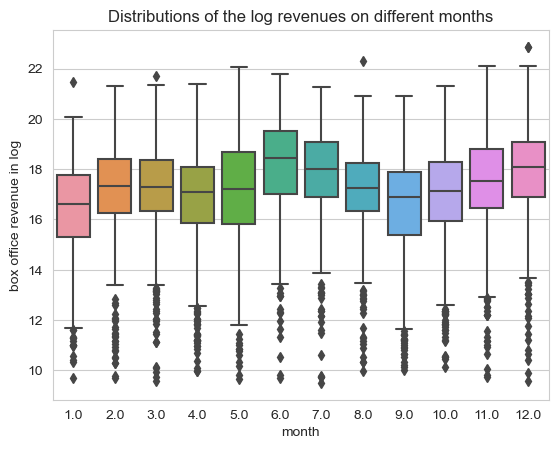

In [238]:
grouped_months = months_df.groupby("Month").mean('log_revenues')
# boxplot of the revenues for each month
sns.boxplot(x='Month', y='log_revenues', data=months_df)
plt.title("Distributions of the log revenues on different months")
plt.ylabel("box office revenue in log")
plt.xlabel("month")
plt.show()

We can see that movies released in july, december and february have higher box offices. Next, we check if there is a link between the percentage of actress and the box office revenue.

In [239]:
stats.spearmanr(gender_df['Percentage_Women'], gender_df['Revenue_with_inflation'])

SignificanceResult(statistic=-0.08966832643024661, pvalue=5.1617017932619725e-16)

Again, by running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and percentage of women actresses are uncorrelated. We will thus further investigate this feature.
We will now perform a discretization of the percentage of women, to divide percentages into 10 group where we have equal number of movies in each group.

In [251]:
# Assuming gender_df is your DataFrame
num_groups = 10

# Sort the DataFrame by 'Percentage_Women'
gender_df = gender_df.sort_values(by='Percentage_Women')

# Create bins based on quantiles
gender_df['group'] = pd.qcut(gender_df['Percentage_Women'], q=num_groups, labels=False, duplicates='drop')

# Display grouped summary
grouped_summary = gender_df.groupby('group').agg({'Percentage_Women': ['count', 'mean', 'min', 'max'],
                                                'Revenue_with_inflation': 'mean'})
display(grouped_summary)

Percentage_Women                     Revenue_with_inflation
                 count       mean min  max                   mean
group                                                            
0                  828   4.771739   0   11           1.025286e+08
1                  853  15.154748  12   18           1.479393e+08
2                  842  21.150831  19   23           1.016303e+08
3                  782  25.636829  24   27           1.181849e+08
4                 1369  31.084003  28   33           1.010295e+08
5                  314  35.417197  34   36           1.491364e+08
6                  776  39.161082  37   41           1.020031e+08
7                  754  44.095491  42   48           1.160373e+08
8                  829  50.671894  50   54           5.895102e+07
9                  798  66.764411  55  100           5.602924e+07

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


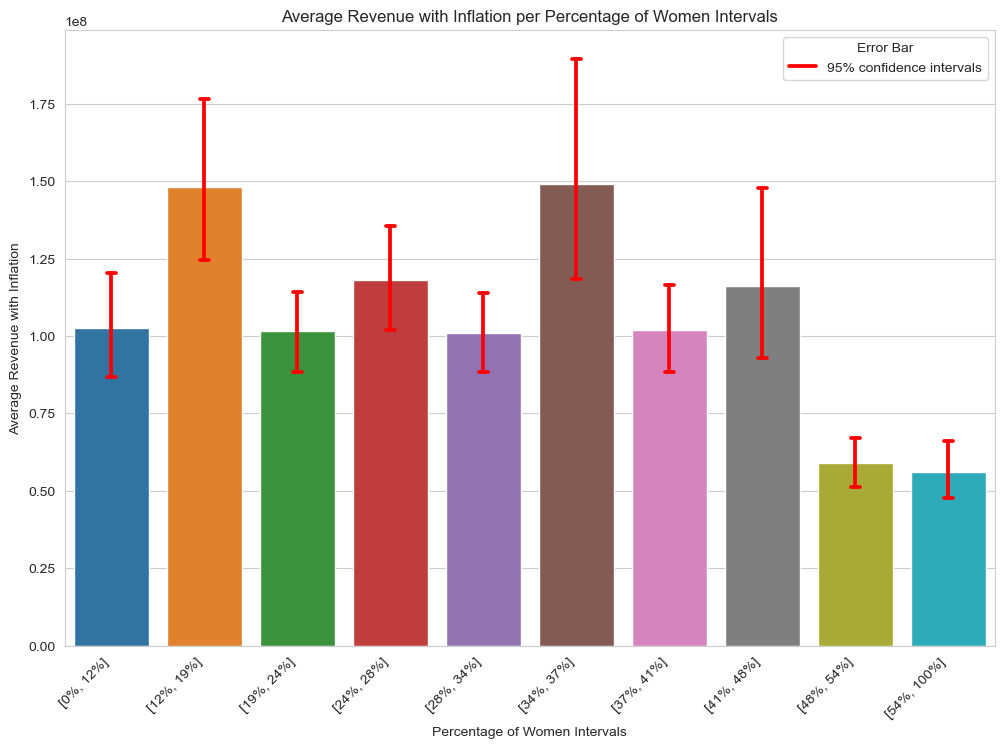

In [258]:
# Boxplot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=gender_df['group'], y=gender_df['Revenue_with_inflation'], estimator='mean', errorbar=('ci', 95), capsize=0.1, errcolor='red')

# Customize x-axis labels
custom_labels = ["[0%, 12%]", "[12%, 19%]", "[19%, 24%]", "[24%, 28%]", "[28%, 34%]", "[34%, 37%]",
                 "[37%, 41%]", "[41%, 48%]", "[48%, 54%]", "[54%, 100%]"]

ax.set_xticklabels(custom_labels, rotation=45, ha='right')

plt.ylim(0, None)
plt.xlabel('Percentage of Women Intervals')
plt.ylabel('Average Revenue with Inflation')
plt.title('Average Revenue with Inflation per Percentage of Women Intervals')

# Add legend
plt.legend(title='Error Bar', labels=['95% confidence intervals'])

plt.show()

From the plot, we can see that movies with women percentage between 12% and 19%, as well as movies with 24% and 28% result in significantly higher box office revenues. While movies with 48% to 100% have significantly lower mean box office revenues.
We will now perform a regression analysis better see if being in one of these groups have a significant impact on the box office. We will use the log revenues as the dependent variable.

In [254]:
# Declares the model
mod = smf.ols(formula='log_revenues ~ C(group)', data=gender_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     19.76
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           3.47e-33
Time:                        16:19:11   Log-Likelihood:                -17596.
No. Observations:                8145   AIC:                         3.521e+04
Df Residuals:                    8135   BIC:                         3.528e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.8055      0.073    230.247

R squared = 0.021 confirms the small correlation between percentage of women and box office revenues. In addition, we can see that group 4 and 6 have p values greater than 0.05, we will thus exclude them from our analysis.

Let's now investigate the link between average box office and discretized box office revenues.

In [255]:
display(years_df)

,Year,Revenue_with_inflation,log_revenues,year_intervals
0,2001,2.315268e+07,16.957621,1994-2003
1,2001,4.855272e+07,17.698161,1994-2003
2,2001,7.559723e+06,15.838345,1994-2003
3,2001,1.176346e+08,18.583094,1994-2003
4,2001,2.331158e+08,19.267046,1994-2003
...,...,...,...,...
8321,1928,8.557164e+07,18.264864,1924-1933
8322,1928,2.344663e+07,16.970237,1924-1933
8323,1928,4.278582e+07,17.571717,1924-1933
8324,1928,2.909436e+07,17.186055,1924-1933


In [263]:
# Declares the model
mod = smf.ols(formula=' log_revenues ~ year_intervals', data=years_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     44.74
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           3.53e-79
Time:                        16:43:23   Log-Likelihood:                -17952.
No. Observations:                8326   AIC:                         3.592e+04
Df Residuals:                    8316   BIC:                         3.599e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Work in progress

## Using the plot_summary dataset, we perform a sentiment analysis over each movie summary extracting positive and negative words to make another feature to predit box office revenues.

In [23]:
#create a copy for the summary metadata
summary_metadata_copy = plot_summaries_df.copy()
print(f"The shape of the summary metadata before removing duplicates is : {summary_metadata_copy.shape}")

#Remove duplicate values
summary_metadata_copy = summary_metadata_copy.drop_duplicates("Movie Summary")
print(f"The shape of the summary metadata after removing duplicates is : {summary_metadata_copy.shape}")

The shape of the summary metadata before removing duplicates is : (42303, 2)
The shape of the summary metadata after removing duplicates is : (42295, 2)


In [24]:
#add a column containing tokenized summaries into words
summary_metadata_copy.loc[:, 'tokenized_summary'] = summary_metadata_copy.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

display(summary_metadata_copy)

,Movie ID,Movie Summary,tokenized_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f..."


In [25]:
#Filter the column containing tokenized text by deleting all stopwords
summary_metadata_copy.loc[:, 'filtered_Tokens'] = summary_metadata_copy['tokenized_summary'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

display(summary_metadata_copy)

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[Shlykov, taxi, driver, Lyosha, saxophonist, d..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, Panem, consists, wealthy, Capitol, tw..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[Poovalli, Induchoodan, sentenced, six, years,..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[Lemon, Drop, Kid, New, York, City, swindler, ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli...","[story, Reema, young, Muslim, schoolgirl, Mala..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks...","[Hollywood, director, Leo, Andreyev, looks, ph..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson...","[American, Luthier, focuses, Randy, Parsons, t..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f...","[Abdur, Rehman, Khan, dry, fruit, seller, Afgh..."


In [ ]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column 
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata_copy['filtered_Tokens'] :
  
  # initialize all the counter to 0
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1
    
  positive_scores.append(nbr_words_pos/nbr_words * 100)
  negative_scores.append(nbr_words_neg/nbr_words * 100)
  neutral_scores.append(nbr_words_neu/nbr_words * 100)

In [ ]:
#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata_copy.loc[:,"percentage of positive words"] = positive_scores
summary_metadata_copy.loc[:,"percentage of negative words"] = negative_scores
summary_metadata_copy.loc[:,"percentage of neutral words"] = neutral_scores
summary_metadata_copy.head(5)

In [ ]:
# Merge the movie and summary dataframes based on the "Movie ID"
movie_summary_metadata = pd.merge(movie_df, summary_metadata_copy, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(3)

## Using the plot_summary dataset, we use NER, or Named Entity Recognition, to identify and classify entities (objects, people, locations, dates, etc.) in each movie summary text, extracting different entities occurences in a text and computing a "score" over these occurences

In [100]:
#create a copy for the summary metadata
summary_metadata_scores = plot_summaries_df.copy()
print(f"The shape of the summary metadata before removing duplicates is : {summary_metadata_copy.shape}")

#Remove duplicate values
summary_metadata_scores = summary_metadata_scores.drop_duplicates("Movie Summary")
print(f"The shape of the summary metadata after removing duplicates is : {summary_metadata_copy.shape}")

The shape of the summary metadata before removing duplicates is : (42295, 4)
The shape of the summary metadata after removing duplicates is : (42295, 4)


In [101]:
#List of entity types and weights (weights are chosen manually)
entity_weights = {
    "PERSON": 1,
    "ORG": 1,
    "GPE": 1,
    "LOC": 1,
    "DATE": 0.5,
    "TIME": 0.5,
    "MONEY": 0.5,
    "PERCENT": 0.5,
    "QUANTITY": 0.5,
    "ORDINAL": 0.5,
    "CARDINAL": 0.5
}

#Function to calculate the score for a summary
def calculate_score(summary):
    doc = nlp(summary)
    
    # Calculate entity occurrences for each sentence
    sentence_scores = []
    for sentence in doc.sents:
        entity_counts = Counter([ent.label_ for ent in sentence.ents])
        sentence_score = sum(entity_counts.get(entity, 0) * weight for entity, weight in entity_weights.items())
        sentence_scores.append(sentence_score)
    #mean over scores of all sentences of each movie summary
    return np.mean(sentence_scores)


file_path = 'external_dataset/movie_score.csv' # Replace with the actual path to your file

if os.path.exists(file_path):
    score = pd.read_csv(file_path)
    summary_metadata_scores['Score'] = score['Score']
else:
    #Add a new column 'Scores' to the DataFrame
    summary_metadata_scores['Score'] = summary_metadata_scores["Movie Summary"].apply(calculate_score)

#Print the resulting DataFrame
display(summary_metadata_scores)

,Movie ID,Movie Summary,Score
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",1.000000
1,31186339,The nation of Panem consists of a wealthy Capi...,1.240385
2,20663735,Poovalli Induchoodan is sentenced for six yea...,2.230769
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",1.183673
4,595909,Seventh-day Adventist Church pastor Michael Ch...,1.633333
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",NaN
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",NaN
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,NaN
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",NaN


In [102]:
# Save scores to avoid unnecessary recomputations each time needed
summary_metadata_scores[['Movie ID','Score']].to_csv('external_dataset/movie_score.csv', index=False)

In [ ]:
# Merge the movie and summary dataframes based on the "Movie ID"
movie_summary_metadata = pd.merge(movie_metadata, summary_metadata_copy, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(3)